> This notebook is designed to run on the Linux DSVM.  Please check the readme file for setup instructions

> The data used here is from NASA Prognostics Center download URL: https://ti.arc.nasa.gov/c/6/, this walkthrough only uses part of that data

> Original link for code: https://github.com/Azure/lstms_for_predictive_maintenance

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
import shutil
import datetime

from sklearn import preprocessing

np.random.seed(1984)
PYTHONHASHSEED = 3

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Configurations dict
configs = {}

# Ingestion 

## Download

In [3]:
!wget https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip -P ./data

--2018-11-15 10:23:37--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘./data/CMAPSSData.zip.6’

CMAPSSData.zip.6    100%[===================>]  11.85M  4.70MB/s    in 2.5s    

2018-11-15 10:23:40 (4.70 MB/s) - ‘./data/CMAPSSData.zip.6’ saved [12425978/12425978]



## Unzip

In [4]:
shutil.unpack_archive('./data/CMAPSSData.zip', './data/unpacked/','zip')

## Load Appropriate Data

In [5]:
configs['cols'] = ['id', 'cycle']
configs['to_normalize'] = []
configs['to_normalize'] = configs['to_normalize'] + ['setting' + str(i) for i in range (1,4)]
configs['to_normalize'] = configs['to_normalize'] + ['s' + str(i) for i in range (1,22)]
configs['cols'] = configs['cols'] + configs['to_normalize']
print('List of columns has {} items.  \nThey are: {}'.format(len(configs['cols']), configs['cols']))

List of columns has 26 items.  
They are: ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [6]:
# read training data 
train_df = pd.read_csv('./data/unpacked/train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = configs['cols']
train_df.head(3)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


In [7]:
# read test data
test_df = pd.read_csv('./data/unpacked/test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = configs['cols']
test_df.head(3)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


In [8]:
# read ground truth data
truth_df = pd.read_csv('./data/unpacked/RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head(3)

,0
0,112
1,98
2,69


In [9]:
print('Shapes of dataframes are:\nTraining: {}\nTesting : {}\nRUL     : {}'
      .format(train_df.shape, test_df.shape, truth_df.shape))

Shapes of dataframes are:
Training: (20631, 26)
Testing : (13096, 26)
RUL     : (100, 1)


We have ~206K training examples, ~130K testing examples.  RUL is result for the testing dataset.  If RUL has 100 entries, this probably means that the testing dataset has data of 100 engines.  Lets validate and check: 

# Exploratory Data Analysis

In [10]:
test_df['id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [11]:
train_df['id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

Both testing and training have 100 engines each.  Remember that the training datasets has running till failures.  

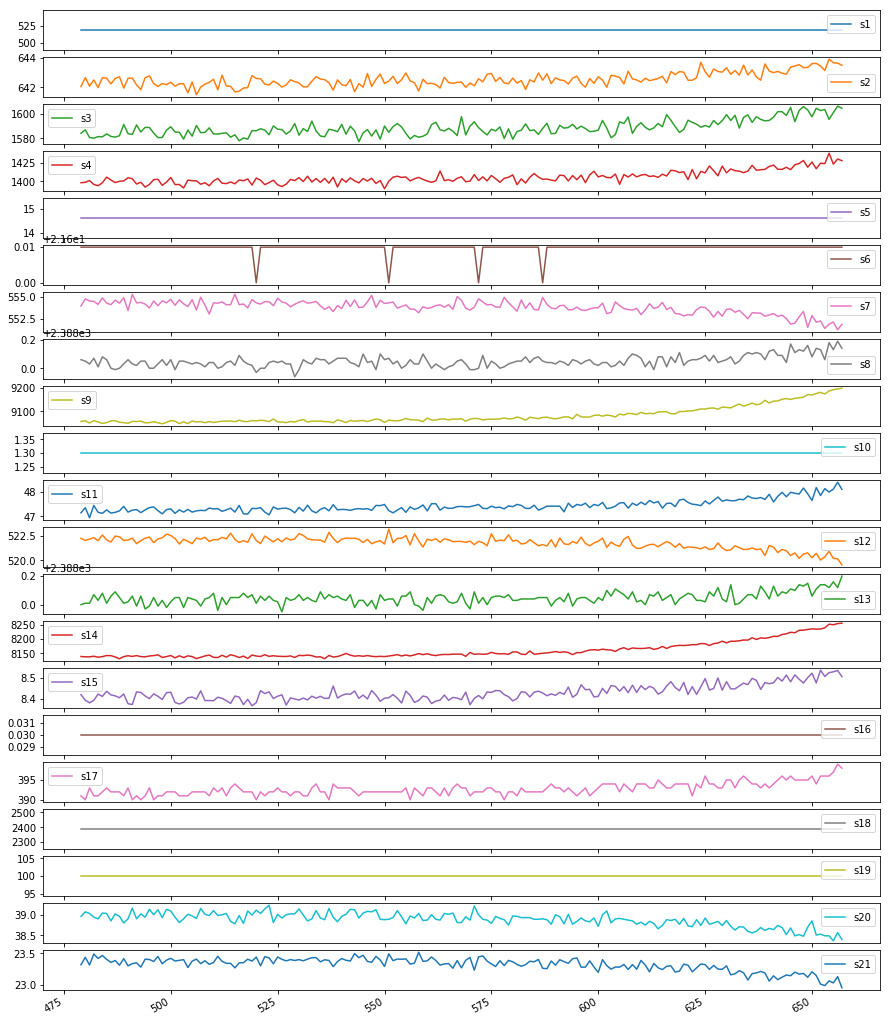

In [12]:
# Looking at the data of the 21 sensors for engine 3.  
_ = (
    train_df[train_df['id']==3][['s'+str(i) for i in range(1,22)]]
    .plot(figsize=(15,20), subplots=True)
)

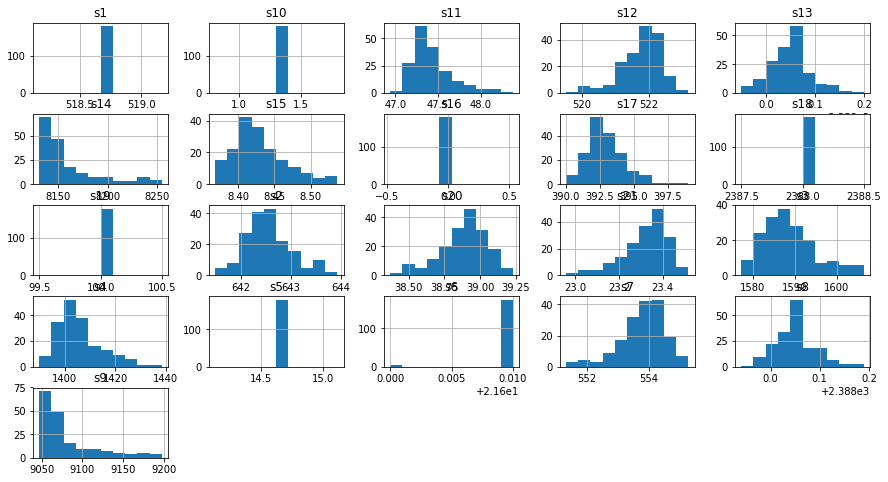

In [13]:
_ = (
    train_df[train_df['id']==3][['s'+str(i) for i in range(1,22)]]
    .hist(figsize=(15,8))
)

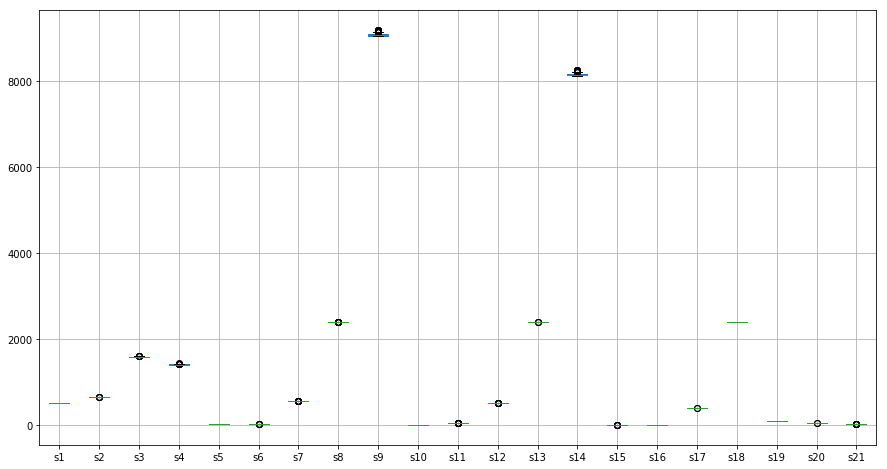

In [14]:
_ = (
    train_df[train_df['id']==3][['s'+str(i) for i in range(1,22)]]
    .boxplot(figsize=(15,8))
)

## Observations from prelim EDA

* It is clear that the sensor data changes as we approach the last cycles.  
* Clearly we could also find correlations and inverse correlations.  
* Next steps: 
    * calculate the remaining useful life at each cycle.  
    * A cycle here is simply a window of time of between 2 readings.  It is unclear for this dataset, this documentation refers to cycles possibly being hours only once.  Sampling might be something you need to do, so here we will have a slight look at how that is done
    * Finally, like any dataset, these numbers need to be normalized.  

# Data Preparation

## Calculate RUL

### Training RUL

In [15]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

In [16]:
rul = train_df.groupby('id')['cycle'].max()
rul = pd.DataFrame(rul).reset_index()
rul.columns = ['id', 'last_cycle']
rul.head()

,id,last_cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


In [17]:
train_df = train_df.merge(rul, on=['id'], how='left')

In [18]:
train_df[train_df['id']==5].head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,last_cycle
847,5,1,0.0031,0.0002,100.0,518.67,641.77,1583.59,1395.26,14.62,...,2388.00,8152.22,8.4102,0.03,393,2388,100.0,38.98,23.4468,269
848,5,2,0.0002,0.0003,100.0,518.67,642.42,1589.69,1394.88,14.62,...,2387.99,8153.04,8.4053,0.03,392,2388,100.0,39.12,23.4075,269
849,5,3,0.0002,-0.0005,100.0,518.67,642.07,1582.45,1396.29,14.62,...,2388.02,8148.42,8.3990,0.03,393,2388,100.0,39.18,23.3298,269
850,5,4,0.0017,-0.0004,100.0,518.67,642.08,1586.84,1397.94,14.62,...,2387.99,8148.81,8.3876,0.03,390,2388,100.0,39.22,23.4306,269
851,5,5,-0.0007,0.0001,100.0,518.67,642.03,1581.45,1394.28,14.62,...,2387.95,8147.69,8.4129,0.03,390,2388,100.0,39.17,23.3331,269


In [19]:
train_df['RUL'] = train_df['last_cycle'] - train_df['cycle']
train_df.drop('last_cycle', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Testing RUL

With the testing dataset, things are a little different.  These engines have not run until failure, at least in the dataset that we have.  So the truth dataframe contains remaining cycles for each engine after the cycles that we have data for in the test dataset.  We need to structure it in the same way we did our training dataset.  What we will do will be as follows: 
* Find the max cycle in the dataset for each engine
* Add to it the data in the truth dataset
* That will give us the RUL at each cycle, rendering this dataset to be equivalent to the one we used in the training dataset

In [20]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'last_cycle_in_test']

In [21]:
truth_df.columns = ['to_add']
truth_df['id'] = range(1,101,1)
truth_df['failure_cycle'] = rul['last_cycle_in_test'] + truth_df['to_add']
truth_df.drop('to_add', axis=1, inplace=True)
truth_df.head()

,id,failure_cycle
0,1,304
1,2,385
2,3,248
3,4,271
4,5,360


Merge with Test dataset

In [22]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['failure_cycle'] - test_df['cycle']
test_df.drop('failure_cycle', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,303
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,302
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,301
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,300
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,299


## Validation Split

In [23]:
print('Original size of training set: {}'.format(train_df.shape))

Original size of training set: (20631, 27)


In [24]:
configs['val_split'] = 0.25

val_df = train_df[train_df['id']%100 >= (1-configs['val_split'])*100]
train_df = train_df[train_df['id']%100 < (1-configs['val_split'])*100]
print('Size of training: {}, size of val: {}'.format(train_df.shape, val_df.shape))

Size of training: (15130, 27), size of val: (5501, 27)


In [25]:
val_df.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)

## Normalizing Data

Columns to be normalized

In [26]:
configs['to_normalize']

['setting1',
 'setting2',
 'setting3',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's20',
 's21']

Columns not going to be normalized

In [27]:
train_df.columns.difference(configs['to_normalize'])

Index(['RUL', 'cycle', 'id'], dtype='object')

Handling the special case of cycle: The only column where we want to keep both the original and normalized column

In [28]:
train_df['cycle_normalized'] = train_df['cycle']
val_df['cycle_normalized'] = val_df['cycle']
test_df['cycle_normalized'] = test_df['cycle']

Adding the normalized cycle to configuration dict lists

In [29]:
configs['to_normalize'].append('cycle_normalized')
configs['cols'].append('cycle_normalized')
configs['new_cols'] = configs['cols'].copy()
configs['new_cols'].append('RUL')

In [30]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(train_df[configs['to_normalize']])

/anaconda/envs/py36-mh/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [31]:
train_df_normalized = pd.DataFrame(scaler.transform(train_df[configs['to_normalize']]),
                                                  columns = configs['to_normalize'], 
                                                  index = train_df.index)
train_df_normalized = (
    train_df[train_df.columns.difference(configs['to_normalize'])]
    .join(train_df_normalized)
    .reindex(columns = configs['new_cols'])
)

train_df_normalized.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_normalized,RUL
0,1,1,0.456647,0.166667,0.0,0.0,0.183735,0.425154,0.257356,0.0,...,0.199608,0.356559,0.0,0.363636,0.0,0.0,0.713178,0.725482,0.00000,191
1,1,2,0.606936,0.250000,0.0,0.0,0.283133,0.473456,0.303487,0.0,...,0.162813,0.404438,0.0,0.363636,0.0,0.0,0.666667,0.732001,0.00277,190
2,1,3,0.248555,0.750000,0.0,0.0,0.343373,0.386193,0.322739,0.0,...,0.171793,0.349942,0.0,0.181818,0.0,0.0,0.627907,0.619473,0.00554,189
3,1,4,0.537572,0.500000,0.0,0.0,0.343373,0.267715,0.280421,0.0,...,0.174889,0.156870,0.0,0.363636,0.0,0.0,0.573643,0.661565,0.00831,188
4,1,5,0.387283,0.333333,0.0,0.0,0.349398,0.269082,0.359426,0.0,...,0.174734,0.395095,0.0,0.454545,0.0,0.0,0.589147,0.704790,0.01108,187


In [32]:
val_df_normalized = pd.DataFrame(scaler.transform(val_df[configs['to_normalize']]),
                                 columns = configs['to_normalize'], 
                                 index = val_df.index)

val_df_normalized = (
    val_df[val_df.columns.difference(configs['to_normalize'])]
    .join(val_df_normalized)
    .reindex(columns = configs['new_cols'])
)

val_df_normalized.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_normalized,RUL
0,75,1,0.485549,0.833333,0.0,0.0,0.268072,0.433356,0.327279,0.0,...,0.116885,0.490074,0.0,0.363636,0.0,0.0,0.651163,0.453656,0.00000,228
1,75,2,0.566474,0.250000,0.0,0.0,0.388554,0.474140,0.278424,0.0,...,0.114873,0.343324,0.0,0.272727,0.0,0.0,0.581395,0.408022,0.00277,227
2,75,3,0.543353,0.333333,0.0,0.0,0.424699,0.474368,0.327279,0.0,...,0.123594,0.384196,0.0,0.272727,0.0,0.0,0.581395,0.499150,0.00554,226
3,75,4,0.589595,0.083333,0.0,0.0,0.385542,0.515607,0.299310,0.0,...,0.141036,0.451538,0.0,0.454545,0.0,0.0,0.565891,0.567319,0.00831,225
4,75,5,0.606936,0.750000,0.0,0.0,0.445783,0.305764,0.395568,0.0,...,0.124935,0.384585,0.0,0.454545,0.0,0.0,0.410853,0.673753,0.01108,224


In [33]:
test_df_normalized = pd.DataFrame(scaler.transform(test_df[configs['to_normalize']]),
                                 columns = configs['to_normalize'], 
                                 index = test_df.index)

test_df_normalized = (
    test_df[test_df.columns.difference(configs['to_normalize'])]
    .join(test_df_normalized)
    .reindex(columns = configs['new_cols'])
)

test_df_normalized.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_normalized,RUL
0,1,1,0.630058,0.750000,0.0,0.0,0.545181,0.324675,0.213948,0.0,...,0.132160,0.300895,0.0,0.363636,0.0,0.0,0.558140,0.660998,0.00000,303
1,1,2,0.341040,0.250000,0.0,0.0,0.150602,0.396674,0.163276,0.0,...,0.204768,0.203970,0.0,0.454545,0.0,0.0,0.682171,0.686650,0.00277,302
2,1,3,0.514451,0.583333,0.0,0.0,0.376506,0.362269,0.270795,0.0,...,0.155640,0.452316,0.0,0.454545,0.0,0.0,0.728682,0.722080,0.00554,301
3,1,4,0.739884,0.500000,0.0,0.0,0.370482,0.298018,0.363058,0.0,...,0.170090,0.248346,0.0,0.272727,0.0,0.0,0.666667,0.661281,0.00831,300
4,1,5,0.578035,0.500000,0.0,0.0,0.391566,0.367965,0.281329,0.0,...,0.152751,0.292721,0.0,0.181818,0.0,0.0,0.658915,0.716978,0.01108,299


## Reshape data for sequence models

Sequence models tend to take a historical snapshot of the data.  So, if I want to predict RUL for a certain engine at a certain cycle, then I want to be able to give the model the last x readings of all sensors.  x here is what we call the sequence length, think of it as the historical length of the data used for predicting the RUL.  Sequence models will need data in the following format size: 

<p style="text-align: center">`sequence length` x `number of features (columns)`</p>

So, if I am looking at 24 historical readings of 6 sensors (for simplicity), then a sigle training example will be an array of: 

<p style="text-align: center">`24` x `6`</p>

This training example will have a single value output (since this is a regression problem).  

In our case, our dataset we have: 
* 21 sensor readings
* 3 settings
* 1 value representing the normalized cycle

25 features, or columns in total.  There is no rule for our sequence length, so we will start with something random such as 24.  We will look at sequence length as a hyperparameter that needs tuning later.  Therefore a single training example will be of the size: 

<p style="text-align: center">`24` x `25`</p>

An extra challenge we need to take care of is that each of the 3 datasets has data for more than 1 engine.  So, the sequence length needs to be distince for each engine.  i.e. a single training example of size `24` x `25`, should theoretically come from the same engine, otherwise our data would be gibberish.  

Finally, a neural network takes the whole dataset, and we select the number of batches we want to train on in a single step.  Therefore, since `24` x `25` is the dimension of a single training example, more formally: 

<p style="text-align: center">`sequence length` x `number of features (columns)`</p>

our full training set therefore should be of the shape: 

<p style="text-align: center">`training examples` x `sequence length` x `number of features (columns)`</p>

i.e. a 3 dimensionnal array.  

Our labels for each 2-d array is a single value, which follows that it should have a size of: 

<p style="text-align: center">`training examples` x `1`</p>

Since we 1 label per training example that is of size (`sequence length` x `number of features (columns)`)

**Note: ** We will not be padding the data, so only full sequence length sequences will be considered

In [34]:
configs['sequence_length'] = 24

### Create the generator function for both data and labels

In [35]:
def seq_generator(df, seq_length, cols):
    data = df[cols].values
    data_len = data.shape[0]
    
    for start, stop in zip(range(0, data_len-seq_length), range(seq_length, data_len)):
        yield data[start:stop, :]

In [36]:
def label_generator(df, seq_length, label):
    data = df[label].values
    data_len = data.shape[0]
    return data[seq_length:data_len, :]

### Generate the 3-d arrays of data and 1-d array of labels

In [37]:
# Conincidently (or not) the same columns we normalized are the ones we need generated historically in terms of trends

train_array = (
    list(
        seq_generator(train_df_normalized[train_df_normalized['id']==id], configs['sequence_length'], configs['to_normalize'])
    ) for id in train_df_normalized['id'].unique()
)

train_array = np.concatenate(list(train_array)).astype(np.float32)
train_array.shape

(13330, 24, 25)

In [38]:
train_labels =[label_generator(train_df_normalized[train_df_normalized['id']==id], configs['sequence_length'], ['RUL']) 
               for id in train_df_normalized['id'].unique()]
train_labels = np.concatenate(train_labels).astype(np.float32)
train_labels.shape

(13330, 1)

In [39]:
val_array = (
    list(
        seq_generator(val_df_normalized[val_df_normalized['id']==id], configs['sequence_length'], configs['to_normalize'])
    ) for id in val_df_normalized['id'].unique()
)

val_array = np.concatenate(list(val_array)).astype(np.float32)
val_array.shape

(4901, 24, 25)

In [40]:
val_labels =[label_generator(val_df_normalized[val_df_normalized['id']==id], configs['sequence_length'], ['RUL']) 
               for id in val_df_normalized['id'].unique()]
val_labels = np.concatenate(val_labels).astype(np.float32)
val_labels.shape

(4901, 1)

In [41]:
test_array = (
    list(
        seq_generator(test_df_normalized[test_df_normalized['id']==id], configs['sequence_length'], configs['to_normalize'])
    ) for id in test_df_normalized['id'].unique()
)

test_array = np.concatenate(list(test_array)).astype(np.float32)
test_array.shape

(10696, 24, 25)

In [42]:
test_labels =[label_generator(test_df_normalized[test_df_normalized['id']==id], configs['sequence_length'], ['RUL']) 
               for id in test_df_normalized['id'].unique()]
test_labels = np.concatenate(test_labels).astype(np.float32)
test_labels.shape

(10696, 1)

In [43]:
configs['num_input_features'] = train_array.shape[2]
configs['layer1_units'] = 100
configs['layer2_units'] = 50
configs['dropout1'] = 0.2
configs['dropout2'] = 0.2

# The Model

## Building the model

In [44]:
model = Sequential()

# First Stage
model.add(
    LSTM(
        input_shape=(configs['sequence_length'], configs['num_input_features']),
        units=configs['layer1_units'],
        return_sequences=True
    )
)
model.add(Dropout(configs['dropout1']))

# Second Stage
model.add(
    LSTM(
        units=configs['layer2_units'],
        return_sequences=False
    )
)
model.add(Dropout(configs['dropout2']))

# Output Stage
model.add(Dense(1))

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________


## Compiling Model

In [46]:
model.compile(loss='mae', optimizer='adam', metrics=['mse'])

## Running the model

In [47]:
# model parameters: 
configs['num_epochs'] = 500
configs['batch_size'] = 4096 # After some testing, 4096 samples loads ~85% of GPU on NC6 machines
configs['callbacks_list'] = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]

In [48]:
%%time
# fit the network
history = model.fit(
    x = train_array, y = train_labels
    , validation_data = (val_array, val_labels)
    , epochs = configs['num_epochs']
    , batch_size = configs['batch_size']
    , verbose=0 # change to 1 for the keras progress bars
    , callbacks = configs['callbacks_list']
)

CPU times: user 6min 23s, sys: 1min 52s, total: 8min 16s
Wall time: 6min 41s


## Evaluating performance of Training

In [49]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

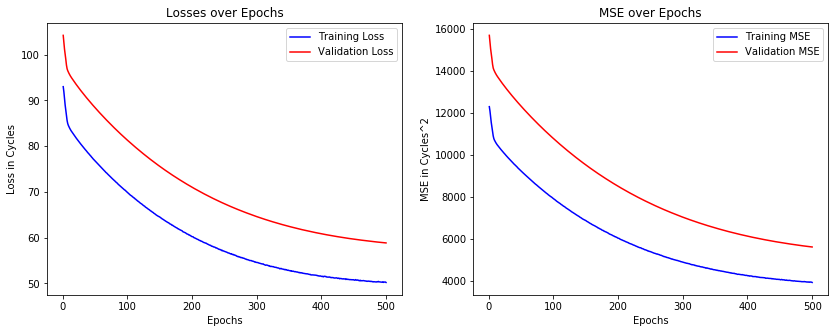

In [50]:
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_mse = history_dict['mean_squared_error']
val_mse = history_dict['val_mean_squared_error']

epochs = range(1, len(val_loss) + 1)

plt.figure(figsize=(14,5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss in Cycles')
plt.title('Losses over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_mse, 'b', label='Training MSE')
plt.plot(epochs, val_mse, 'r', label='Validation MSE')
plt.ylabel('MSE in Cycles^2')
plt.title('MSE over Epochs')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [51]:
train_mae = model.evaluate(x=train_array, y=train_labels)
test_mae = model.evaluate(x=test_array, y=test_labels)
val_mae = model.evaluate(x=val_array, y=val_labels)

4901/4901 [==============================] - 4s 842us/step


In [52]:
print('\
Training set MAE    : {:.2f}\n\
Validation set MAE  : {:.2f}\n\
Test set MAE        : {:.2f}\n\n\
Training set MSE    : {:.2f}\n\
Validation set MSE  : {:.2f}\n\
Test set MSE        : {:.2f}\
      '.format(train_mae[0], val_mae[0], test_mae[0], train_mae[1], val_mae[1], test_mae[1]))

Training set MAE    : 50.07
Validation set MAE  : 58.86
Test set MAE        : 105.94

Training set MSE    : 3900.46
Validation set MSE  : 5611.38
Test set MSE        : 16328.89      


## Save Model

In [53]:
now = datetime.datetime.now()
time_stamp = now.strftime("%Y%m%d%H%M")
model.save('{}_pdm.h5'.format(time_stamp))

Test Save/Load

In [55]:
del model
model = load_model('{}_pdm.h5'.format(time_stamp))
test_mae = model.evaluate(x=test_array, y=test_labels)
print('\
Test set MAE        : {:.2f}\n\
Test set MSE        : {:.2f}\
      '.format(test_mae[0], test_mae[1]))

10696/10696 [==============================] - 11s 988us/step
Test set MAE        : 105.94
Test set MSE        : 16328.89      


Saving and loading works fine.  If you load without saving in same session, make sure to change the name of the loaded file.  

# Next Steps

Condsider the following: 
* Tune parameters
* Check other methods (vs RUL), such as will it fail in the next 20 cycles? A binary classification problem, one that is unbalanced.  
* Is the callback good enough for early stopping? seems like we need more training
* More data would help but not an option, we need to tune the model.  
* Using AML Services + hyperdrive for hyper-parameter training